In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
from sequence_jacobian import simple, create_model, grids

In [2]:
plt.rcParams.update({'font.size': 13})

##### This notebook replicates McKay, Nakamura and Steinsson (2016) on forward guidance puzzle and decomposes the IRFs into RANK and redistribution effects using the method from Gong(2025). The decomposition algorithm is from the simplified algorithm described in Appendix B.1 of Gong(2025).

# A. HANK

## A.1 Households block

In [3]:
import hh_labor
hh = hh_labor.hh

In [4]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    #e_grid, pi_e, Pi = grids.markov_tauchen(rho=rho_e, sigma=sd_e, N=nE, normalize=True)
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, pi_e, Pi, a_grid

def transfers(pi_e, Div, Tax, tax_rule, div_rule):
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

def wages(w, e_grid):
    we = w * e_grid
    return we

def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

In [5]:
hh_ha = hh.add_hetinputs([make_grid, transfers, wages]).add_hetoutputs([labor_supply])

## A.2 Simple Blocks

In [6]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L
    return L, Div

@simple
def monetary(pi, r, phi, rstar):
    i = rstar + phi * pi
    fisher = (1 + r) * (1 + pi(+1)) - 1 - i
    return fisher, i

@simple
def fiscal(r, B):
    Tax = r / (1+r) * B
    return Tax

@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

## A.3 Steady state

In [7]:
blocks_ss = [hh_ha, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

In [8]:
calibration = {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.96566, 'sd_e': 0.5011, 'nE': 3, 
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.045, 'r': 0.005, 'phi': 1.5, 'B': 5.5,
               'Tss': 5.5 * 0.005 / (1 + 0.005), 'borr_cons': 0, 'rstar': 0.005}

#sd_e = sqrt(0.01695/(1-0.96566^2)) = 0.5011; sd_innovation = 0.01695
calibration['tax_rule'] = np.zeros(calibration['nE'])
calibration['tax_rule'][-1] = 1
calibration['div_rule'] = np.ones(calibration['nE'])

unknowns_ss = {'beta': 0.986, 'vphi': 1}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0 }

ss = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

In [9]:
print(ss['beta'], ss['asset_mkt'], ss['goods_mkt'], ss['labor_mkt'])

0.9859441168555392 7.460698725481052e-14 -4.271927256382924e-09 -1.2212453270876722e-15


## A.4 The monetary policy shock

In [10]:
blocks = [hh_ha, firm, monetary, fiscal, mkt_clearing, nkpc]
HA = create_model(blocks, name="One-Asset HANK")
ss_ha = HA.steady_state(ss)

In [11]:
T = 300
dr = np.zeros(T)
dr[20] = -0.005

In [12]:
unknowns = ['rstar', 'pi', 'w', 'Y']
targets = ['fisher','nkpc_res', 'asset_mkt', 'labor_mkt']
G_HA = HA.solve_impulse_linear(ss_ha, unknowns, targets, {'r': dr})
# Alternative: solve nonlinear impulse response and get individual level responses (and decompositions).
# In the paper, this model is solved nonlinearly so the results are slightly different.
# G_HA = HA.solve_impulse_nonlinear(ss_ha, unknowns, targets, {'r': dr}, verbose= False, internals='hh')

# B. RANK effects

## B.1 IRFs of the representative agent

In [13]:
@simple
def hh_ra(Y, w, eis, vphi, frisch, beta, r):
    C = Y
    euler = (beta * (1 + r)) ** (-eis) * C(+1) - C
    N = (w / vphi / C ** (1 / eis)) ** (frisch)
    return  euler, N, C

@simple
def mkt_clearing_ra(N, L, C, Y):
    labor_mkt = N - L
    goods_mkt = Y - C 
    return  goods_mkt, labor_mkt

In [14]:
calibration_ra = calibration|ss.toplevel
calibration_ra['beta']=  1/(1+ss['r'])
calibration_ra['vphi'] = ss['w'] * ss['C'] ** (-1/ss['eis']) * ss['NE'] ** (-1/ss['frisch'])

In [15]:
blocks_ra = [hh_ra, firm, monetary, fiscal, mkt_clearing_ra, nkpc]
RA = create_model(blocks_ra, name="Representative Agent Model")
ss_ra = RA.steady_state(calibration_ra)

In [16]:
unknowns_ra = ['rstar', 'w', 'Y', 'pi']
targets_ra = ['fisher', 'euler', 'labor_mkt', 'nkpc_res']
G_RA = RA.solve_impulse_linear(ss_ra, unknowns_ra, targets_ra, {'r': dr})

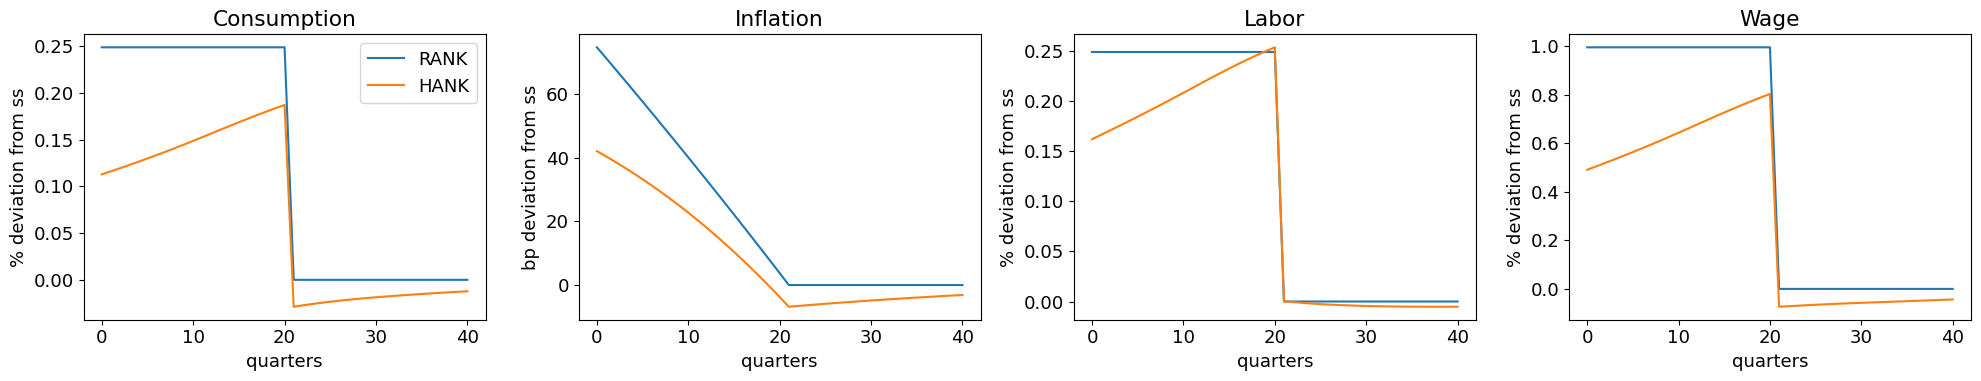

In [17]:
plt.figure(figsize=[20,4])

plt.subplot(1,4,1)
plt.plot(100 * G_RA['C'][:41] / ss_ra['C'],  label='RANK')
plt.plot(100 * G_HA['Y'][:41] / ss_ha['Y'],  label='HANK')
plt.title(r'Consumption')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()

plt.subplot(1,4,2)
plt.plot(10000 * G_RA['pi'][:41])
plt.plot(10000 * G_HA['pi'][:41])
plt.title(r'Inflation')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')

plt.subplot(1,4,3)
plt.plot(100 * G_RA['N'][:41] / ss_ra['N'])
plt.plot(100 * G_HA['N'][:41] / ss_ha['N'])
plt.title(r'Labor')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')

plt.subplot(1,4,4)
plt.plot(100 * G_RA['w'][:41] / ss_ra['w'])
plt.plot(100 * G_HA['w'][:41] / ss_ha['w'])
plt.title(r'Wage')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')

plt.tight_layout()
plt.show()

## B.2 Redistribution channels

In [ ]:
# tax exposure
def tax_exp(dr_tax, pi_e):
    dT = ss['B'] * (ss['r'] + dr_tax) / (1 + ss['r'] + dr_tax) - ss['Tax']
    tax_exp = dT * (1 - 1 / np.sum(pi_e * ss['tax_rule']) * ss['tax_rule'])
    return tax_exp

# income exposure
def inc_exp(dw_inc, dY_inc, dDiv_inc, div_rule, pi_e):
    y_ss = ss.internals['hh']['ne'] * ss['w'] + (div_rule / np.sum(pi_e * div_rule) * ss['Div'])[:, np.newaxis]
    y_HA = ss.internals['hh']['ne'] * (1 + dY_inc/ss['Y']) * (ss['w'] + dw_inc)\
    + (div_rule / np.sum(pi_e * div_rule) * (ss['Div']+ dDiv_inc))[:, np.newaxis]
    delta_y_HA = y_HA - y_ss
    inc_exp = delta_y_HA - dY_inc / ss['Y'] * y_ss
    return inc_exp

# interest exposure
def int_exp(dr_int, a_grid):
    int_exp = (a_grid - ss['B']) * (1 / (1+ ss['r']) - 1 / (1+ ss['r'] + dr_int))  
    return int_exp

# saving flow exposure
def saving_flow(dC_sav, div_rule, pi_e):
    y_ss = ss.internals['hh']['ne'] * ss['w'] + (div_rule / np.sum(pi_e * div_rule) * ss['Div'])[:, np.newaxis]
    saving_flow = dC_sav/ss['C'] * (y_ss - ss.internals['hh']['c'])
    return saving_flow

# the sum of all channels
def redistribution(tax_exp, inc_exp, int_exp, saving_flow):
    re_shock = tax_exp[:, np.newaxis] + inc_exp + int_exp + saving_flow
    return re_shock

# C. Redistribution Effects

In [19]:
import hh_labor_re
hh_re = hh_labor_re.hh
hh_re = hh_re.add_hetinputs([make_grid, transfers, wages, redistribution, \
                             tax_exp, inc_exp, int_exp, saving_flow]).add_hetoutputs([labor_supply])
blocks_re = [hh_re, firm, monetary, fiscal, nkpc, mkt_clearing]
RE = create_model(blocks_re, name="redistribution effects")

In [20]:
ca_re = ss.toplevel.copy()
# Initialize all shock variables to zero for the steady state
for key in ['dw_inc', 'dY_inc', 'dDiv_inc', 'dr_tax', 'dr_int', 'dC_sav']:
    ca_re[key] = 0
ss_re = RE.steady_state(ca_re)

In [21]:
G_RE_tax = RE.solve_impulse_linear(ss_re, unknowns, targets, {'dr_tax': G_RA['r']})
G_RE_inc = RE.solve_impulse_linear(ss_re, unknowns, targets, {'dw_inc': G_RA['w'], 'dY_inc': G_RA['Y'], 'dDiv_inc': G_RA['Div'] })
G_RE_int = RE.solve_impulse_linear(ss_re, unknowns, targets, {'dr_int': G_RA['r'] })
G_RE_sav = RE.solve_impulse_linear(ss_re, unknowns, targets, {'dC_sav': G_RA['C']})

In [22]:
G_RE =RE.solve_impulse_linear(ss_re, unknowns, targets, \
                                 {'dr_tax': G_RA['r'], 'dw_inc': G_RA['w'], 'dY_inc': G_RA['Y'], 'dDiv_inc': G_RA['Div'], \
                                'dr_int': G_RA['r'],'dC_sav': G_RA['C']})

# D. Results

In [23]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyles = ['dashdot', 'dotted', 'dashed', (0, (3, 1, 1, 1)), (0, (3, 1, 1, 2)), (0, (3, 1, 1, 1, 1, 1))]
# Define consistent colors and linestyles for each channel
interest_rate_color = colors[0]  # Blue
portfolio_income_color = colors[1]  # Orange
liquidity_color = colors[2]  # Green
tax_color = colors[3]  # Red
labor_income_color = colors[4]  # Purple

interest_rate_linestyle = linestyles[0]
portfolio_income_linestyle = linestyles[1]
liquidity_linestyle = linestyles[2]
tax_linestyle = linestyles[3]
labor_income_linestyle = linestyles[4]

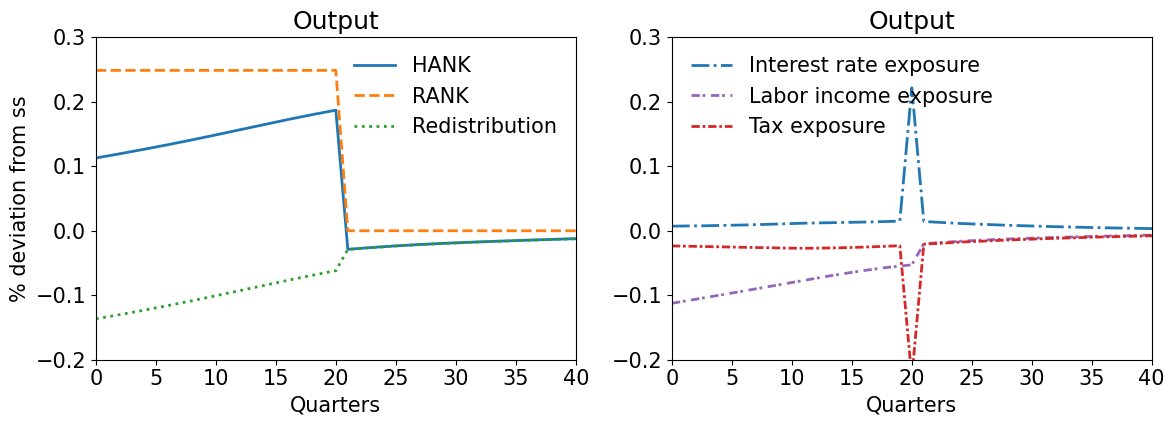

In [24]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=[12,4.5])
lw=2.5
length = 40

plt.subplot(1,2,1)
plt.plot(100 * G_HA['C'] / ss['C'], label='HANK', linestyle='solid', linewidth=2)
plt.plot(100 * G_RA['C'] / ss['C'], label='RANK', linestyle='dashed', linewidth=2)
plt.plot(100 * G_RE['C'] / ss['C'], label='Redistribution', linestyle='dotted', linewidth=2)
plt.title(r'Output')
plt.xlabel('Quarters'), plt.ylabel('% deviation from ss')
plt.legend(loc='upper right',framealpha=0)
plt.xlim([0, length])
plt.xticks(np.arange(0, length+1, 5))
plt.ylim([-0.2, 0.3])
plt.yticks(np.arange(-0.2, 0.35, 0.1))

plt.subplot(1,2,2)
plt.plot(100 * G_RE_int['C'] / ss['C'], label='Interest rate exposure', color=interest_rate_color,linestyle=interest_rate_linestyle, linewidth=2)
plt.plot(100 * G_RE_inc['C'] / ss['C'], label='Labor income exposure', color=labor_income_color,linestyle=labor_income_linestyle, linewidth=2)
plt.plot(100 * G_RE_tax['C'] / ss['C'], label='Tax exposure', color=tax_color, linestyle=tax_linestyle, linewidth=2)
plt.title(r'Output')
plt.xlabel('Quarters')
plt.xlim([0, length])
plt.xticks(np.arange(0, length+1, 5))
plt.ylim([-0.2, 0.3])
plt.yticks(np.arange(-0.2, 0.35, 0.1))
plt.legend(loc='upper left', framealpha=0)

plt.tight_layout()
#plt.savefig('results/mns2016.pdf')
plt.show()

In [27]:
def contribution(length):
    """
    Calculate the simple cumulative contribution of each channel to aggregate consumption over a given horizon.

    Returns:
        tuple: (RE_share, RE_inc_share, RE_tax_share, RE_int_share, RE_res_share, RA_share)
    """
    # Aggregate responses up to the specified length (inclusive)
    RE = np.sum(G_RE['C'][:length+1])
    RE_tax = np.sum(G_RE_tax['C'][:length+1])
    RE_inc = np.sum(G_RE_inc['C'][:length+1])
    RE_int = np.sum(G_RE_int['C'][:length+1])
    RE_sav = np.sum(G_RE_sav['C'][:length+1])
    RA = np.sum(G_RA['C'][:length+1])
    HA = np.sum(G_HA['C'][:length+1])

    # Avoid division by zero
    if HA == 0:
        raise ValueError("Sum of HANK consumption response is zero, cannot compute shares.")

    RE_share = 100 * RE / HA
    RE_tax_share = 100 * RE_tax / HA
    RE_inc_share = 100 * RE_inc / HA
    RE_int_share = 100 * RE_int / HA
    RE_res_share = 100 * RE_sav / HA
    RA_share = 100 * RA / HA

    return RE_share, RE_inc_share, RE_tax_share, RE_int_share, RE_res_share, RA_share

print(contribution(300))

(-105.43165726608929, -79.48256757373575, -43.87852894228316, 24.247984795482346, -6.318545545552682, 204.68195979466768)


## D.2 Household level Decompositition  

#### The above codes solve the model linearly. If the model is solved nonlinearly, we can ask the sequence space package to return individual-level IRFs. We can also plot the individual-level decompositions.

In [ ]:
# weal_d = np.sum(ss.internals['hh']['D'],axis=0)
# cum_weal_d = np.cumsum(weal_d)

In [ ]:
# fig = plt.figure(figsize=[15,4])

# plt.subplot(1,3,1)
# plt.plot(cum_weal_d, 100 * G_HA.internals['hh']['c'][0,0,:]/ss.internals['hh']['c'][0,:], label='HANK', linestyle='-', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RA['C'][0] * np.ones(500), label='RANK', linestyle='dashed', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RE_int.internals['hh']['c'][0,0,:]/ss.internals['hh']['c'][0,:], label='Interest rate exposure', linestyle='dotted', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RE_inc.internals['hh']['c'][0,0,:]/ss.internals['hh']['c'][0,:], label='Income exposure', linestyle='dashdot', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RE_tax.internals['hh']['c'][0,0,:]/ss.internals['hh']['c'][0,:], label='Tax exposure', linestyle=(0, (3,1,3,1)), linewidth=2)
# plt.xlabel('Wealth Percentile')
# plt.ylabel('% deviation from ss')
# plt.title('Consumption ($z_1$)')

# plt.subplot(1,3,2)
# plt.plot(cum_weal_d, 100 * G_HA.internals['hh']['c'][0,1,:]/ss.internals['hh']['c'][1,:], linestyle='-', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RA['C'][0] * np.ones(500), linestyle='dashed', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RE_int.internals['hh']['c'][0,1,:]/ss.internals['hh']['c'][1,:], linestyle='dotted', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RE_inc.internals['hh']['c'][0,1,:]/ss.internals['hh']['c'][1,:], linestyle='dashdot', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RE_tax.internals['hh']['c'][0,1,:]/ss.internals['hh']['c'][1,:], linestyle=(0, (3,1,3,1)), linewidth=2)
# plt.xlabel('Wealth Percentile')
# plt.title('Consumption ($z_2$)')

# plt.subplot(1,3,3)
# plt.plot(cum_weal_d, 100 * G_HA.internals['hh']['c'][0,2,:]/ss.internals['hh']['c'][2,:], linestyle='-', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RA['C'][0] * np.ones(500), linestyle='dashed', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RE_int.internals['hh']['c'][0,2,:]/ss.internals['hh']['c'][2,:], linestyle='dotted', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RE_inc.internals['hh']['c'][0,2,:]/ss.internals['hh']['c'][2,:], linestyle='dashdot', linewidth=2)
# plt.plot(cum_weal_d, 100 * G_RE_tax.internals['hh']['c'][0,2,:]/ss.internals['hh']['c'][2,:], linestyle=(0, (3,1,3,1)), linewidth=2)
# plt.xlabel('Wealth Percentile')
# plt.title('Consumption ($z_3$)')

# fig.legend(bbox_to_anchor=(0.17, -0.1, 0.7, 0.1), mode='expand', ncol=3)
# fig.tight_layout()
# plt.show()
# #fig.savefig('results/hh_decom.pdf', bbox_inches="tight")